# Embedding Generation
This example performs generation of a single embedding vector from a 16x16 Sentinel-2 RGB image patch with TerraMind.

In [1]:
from pathlib import Path

import torch
import rioxarray as rxr
from huggingface_hub import hf_hub_download
from terratorch.registry import BACKBONE_REGISTRY
import numpy as np

# Select device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

/Users/jonathangiezendanner/terratorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:
# build model
model = BACKBONE_REGISTRY.build(
    "terramind_v1_base",
    # modalities=["S2L2A"], # all S2 bands
    modalities=["S2RGB"], # S2 RGB bands
    pretrained=True,
)

model = model.to(device)

In [3]:
model.eval()

TerraMindViT(
  (encoder_embeddings): ModuleDict(
    (untok_sen2rgb@224): ImageEncoderEmbedding(
      (proj): Linear(in_features=768, out_features=768, bias=False)
    )
  )
  (encoder): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm()
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=False)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm()
      (mlp): GatedMlp(
        (fc1): Linear(in_features=768, out_features=2048, bias=False)
        (act): SiLU()
        (fc2): Linear(in_features=2048, out_features=768, bias=False)
        (fc3): Linear(in_features=768, out_features=2048, bias=False)
      )
    )
  )
  (encoder_norm): LayerNorm()
  (tokenizer): ModuleDict()
)

In [4]:
# Download image if necessary
image_path = Path('examples/S2L2A/Santiago.tif')
if not image_path.exists():
    hf_hub_download(repo_id='ibm-esa-geospatial/Examples', filename='S2L2A/Santiago.tif', repo_type='dataset', local_dir='examples/')

In [5]:
means={
  "S2L2A": [1390.458, 1503.317, 1718.197, 1853.910, 2199.100, 2779.975, 2987.011, 3083.234, 3132.220, 3162.988, 2424.884, 1857.648],
}
stds={
  "S2L2A": [2106.761, 2141.107, 2038.973, 2134.138, 2085.321, 1889.926, 1820.257, 1871.918, 1753.829, 1797.379, 1434.261, 1334.311],
}

In [6]:
# Open image
data = rxr.open_rasterio(image_path).values
# Select RGB image of dimension 16x16,, and normalisee with pre-computed values
data = ((data[[3,2,1], 0:16, 0:16]
        - np.array(means['S2L2A'])[[3,2,1]][:, None, None])/
          np.array(stds['S2L2A'])[[3,2,1]][:, None, None])
data.shape

(3, 16, 16)

In [7]:
#create torch input
input = torch.tensor(data, dtype=torch.float, device=device).unsqueeze(0)
input.shape

torch.Size([1, 3, 16, 16])

## Retrieve Embedding

In [8]:
# we evaluate the pretrained model on the embedding and retrieve the last layer
with torch.no_grad():
    embedding = model(input)[-1]
embedding = embedding.cpu().squeeze().numpy()

In [9]:
# print output embedding
embedding.shape

(768,)

In [10]:
embedding

array([-1.05185461e+00, -2.96659052e-01, -4.40784097e-01, -1.09374428e+00,
       -1.83860093e-01, -6.45335197e-01,  2.95654297e-01,  5.62499523e-01,
       -9.57847178e-01, -3.17983890e+00,  4.16670024e-01,  3.98576781e-02,
       -8.69262964e-02,  2.10801557e-01,  4.03485149e-01,  1.21850669e+00,
        4.07431036e-01,  1.40248418e-01,  3.20111960e-01,  3.56350422e-01,
       -5.40736318e-01,  4.95276093e-01, -9.75980759e-02,  6.01038992e-01,
       -2.10025817e-01,  7.08338201e-01, -9.81072366e-01, -2.55511165e-01,
       -2.47449920e-01,  6.22350387e-02,  1.43448949e-01,  6.90883398e-01,
        1.05935261e-01, -1.09017551e+00,  3.03466380e-01, -3.42815965e-02,
       -4.50023621e-01,  7.75412098e-02, -9.94802177e-01,  6.56497657e-01,
        4.07347381e-01,  6.63134530e-02, -4.30926442e-01, -1.77112728e-01,
        4.36142683e-01,  5.32098293e-01,  4.04113084e-02,  8.86695921e-01,
       -2.32016034e-02, -6.63361490e-01, -5.71947470e-02,  5.12252808e-01,
        2.26341531e-01,  

In [11]:
import matplotlib.pylab as plt

(0.0, 768.0)

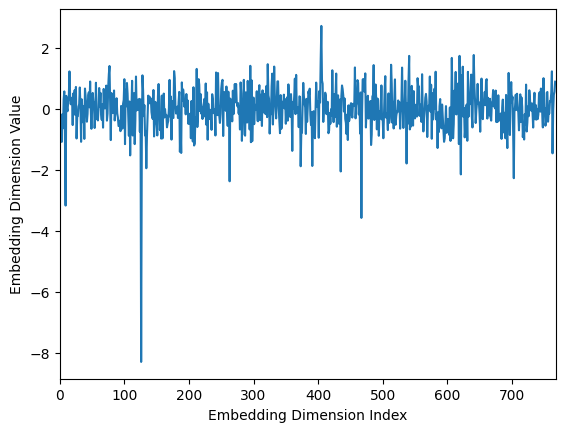

In [12]:
plt.plot(embedding)
plt.xlabel('Embedding Dimension Index')
plt.ylabel('Embedding Dimension Value')
plt.xlim([0, len(embedding)])